<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Токенизация-и-лемматизация:" data-toc-modified-id="Токенизация-и-лемматизация:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Токенизация и лемматизация:</a></span></li><li><span><a href="#Выделение-тестовой-выборки:" data-toc-modified-id="Выделение-тестовой-выборки:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Выделение тестовой выборки:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Мешок-слов" data-toc-modified-id="Мешок-слов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Мешок слов</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
from pymystem3 import Mystem
m = Mystem()

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv(r'/datasets/toxic_comments.csv')
corpus = data['text'].str.lower().values.astype('U')
data.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


### Токенизация и лемматизация:

In [3]:
def lemmatized(text):
    cleared_text = re.sub(r'[^a-z]', ' ', text)
    lemm_list = m.lemmatize(' '.join(cleared_text.split()))
    return ''.join(lemm_list)

In [4]:
lem_text = []
for text in tqdm(corpus):
    lem_text.append(lemmatized(text))

In [5]:
lem_text[:5]

['explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now\n',
 'd aww he matches this background colour i m seemingly stuck with thanks talk january utc\n',
 'hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info\n',
 'more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know th

### Выделение тестовой выборки:

In [6]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(lem_text, data['toxic'],
                                                             stratify=data['toxic'],
                                                             test_size=0.3, random_state=12321)

In [7]:
pd.DataFrame({'Размер выборки':[y_train.shape[0], y_test.shape[0]], 
              'Баланс цели':[y_train.mean(), y_test.mean()]},
              ['Тренировочная выборка', 'Тестовая выборка'])

,Размер выборки,Баланс цели
Тренировочная выборка,111699,0.101675
Тестовая выборка,47872,0.101688


## Обучение

### Мешок слов

In [8]:
bow_count_vect = CountVectorizer(stop_words=stop_words)

In [9]:
%%time
X_train_bow = bow_count_vect.fit_transform(X_train_raw)

CPU times: user 8.74 s, sys: 55.7 ms, total: 8.79 s
Wall time: 8.82 s


In [10]:
X_train_bow.shape

(111699, 137795)

In [11]:
%%time
X_test_bow = bow_count_vect.transform(X_test_raw)

CPU times: user 3.71 s, sys: 0 ns, total: 3.71 s
Wall time: 3.75 s


In [12]:
X_test_bow.shape

(47872, 137795)

In [13]:
LR_bow = LogisticRegression(max_iter=1000, 
                            solver='lbfgs',
                            class_weight='balanced',
                            n_jobs=-1,
                            random_state=12321)

In [14]:
%%time
LR_bow.fit(X_train_bow, y_train)

CPU times: user 2min 44s, sys: 3min 14s, total: 5min 59s
Wall time: 5min 59s


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=12321, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
pd.DataFrame({'F1 score':
              [f1_score(y_train, LR_bow.predict(X_train_bow)), 
               f1_score(y_test, LR_bow.predict(X_test_bow))]
             }, ['Тренировочная выборка', 'Тестовая выборка'])

,F1 score
Тренировочная выборка,0.919142
Тестовая выборка,0.763629


### TF-IDF

In [16]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 

In [17]:
%%time
X_train_tf_idf = count_tf_idf.fit_transform(X_train_raw)
X_train_tf_idf.shape

CPU times: user 10.2 s, sys: 35.6 ms, total: 10.3 s
Wall time: 10.6 s


(111699, 137795)

In [18]:
%%time
X_test_tf_idf = count_tf_idf.transform(X_test_raw)
X_test_tf_idf.shape

CPU times: user 4.29 s, sys: 0 ns, total: 4.29 s
Wall time: 4.38 s


(47872, 137795)

In [19]:
LR_tf_idf = LogisticRegression(max_iter=1000, 
                               solver='lbfgs', 
                               class_weight='balanced',
                               n_jobs=-1,
                               random_state=12321)

In [20]:
%%time
LR_tf_idf.fit(X_train_tf_idf, y_train)

CPU times: user 38.7 s, sys: 43.5 s, total: 1min 22s
Wall time: 1min 22s


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=12321, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
pd.DataFrame({'F1 score':
              [f1_score(y_train, LR_tf_idf.predict(X_train_tf_idf)), 
               f1_score(y_test, LR_tf_idf.predict(X_test_tf_idf))]
             }, ['Тренировочная выборка', 'Тестовая выборка'])

,F1 score
Тренировочная выборка,0.843555
Тестовая выборка,0.750639


---

## Выводы

Рассмотрены две модели логистической регрессии, обученных на данных, векторизированных двумя способами:
1. Мешок слов
2. TF-IDF  

Обе модели удовлетворяют заданому критерию метрики качества F1 не меньше 0.75.  
Первая модель показала чуть лучшее значение метрики F1, но обучается примерно в 4 раза дольше.  
Кроме этого, вторая модель менее склонна к переобучению.

---  
Дополнительные метрики:

In [22]:
predict_bow = LR_bow.predict(X_test_bow)
probabilities_bow = LR_bow.predict_proba(X_test_bow)[:, 1]
fpr_bow, tpr_bow, thresholds_bow = roc_curve(y_test, probabilities_bow)
roc_auc_bow = roc_auc_score(y_test, probabilities_bow)

predict_tf_idf = LR_tf_idf.predict(X_test_tf_idf)
probabilities_tf_idf = LR_tf_idf.predict_proba(X_test_tf_idf)[:, 1]
fpr_tf_idf, tpr_tf_idf, thresholds_tf_idf = roc_curve(y_test, probabilities_tf_idf)
roc_auc_tf_idf = roc_auc_score(y_test, probabilities_tf_idf)

In [23]:
print('--------------------------\nЛогистическая регрессия на BOW:')
display(pd.DataFrame(classification_report(y_test, predict_bow, output_dict=True)).round(3).T[:3])
display(pd.DataFrame(confusion_matrix(y_test, predict_bow)))
print('-----------------------------\nЛогистическая регрессия на TF_IDF:')
display(pd.DataFrame(classification_report(y_test, predict_tf_idf, output_dict=True)).round(3).T[:3])
display(pd.DataFrame(confusion_matrix(y_test, predict_tf_idf)))

--------------------------
Логистическая регрессия на BOW:


,precision,recall,f1-score,support
0,0.979,0.963,0.971,43004.000
1,0.716,0.819,0.764,4868.000
accuracy,0.948,0.948,0.948,0.948


,0,1
0,41420,1584
1,883,3985


-----------------------------
Логистическая регрессия на TF_IDF:


,precision,recall,f1-score,support
0,0.982,0.954,0.968,43004.000
1,0.675,0.845,0.751,4868.000
accuracy,0.943,0.943,0.943,0.943


,0,1
0,41028,1976
1,756,4112


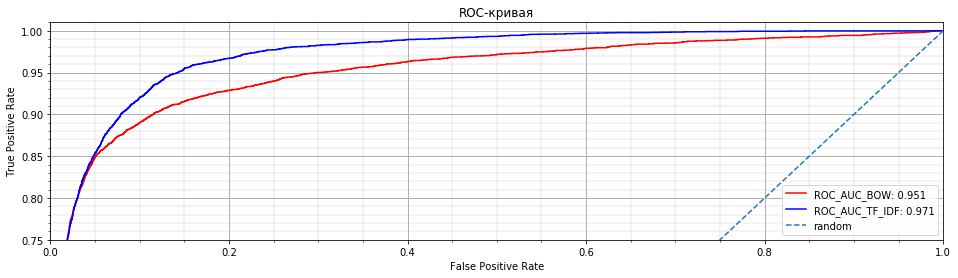

In [24]:
plt.figure(figsize=(16,4))
plt.plot(fpr_bow, tpr_bow, 'r-', label= 'ROC_AUC_BOW: %.3f'%roc_auc_bow) 
plt.plot(fpr_tf_idf, tpr_tf_idf, 'b-', label='ROC_AUC_TF_IDF: %.3f'%roc_auc_tf_idf)
plt.plot([0, 1], [0, 1], linestyle='--', label='random')

plt.xlim([0.0, 1.0]); plt.ylim([0.75, 1.01])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC-кривая')

plt.legend(); plt.minorticks_on()
plt.grid(which='major', linewidth = 1); plt.grid(which='minor', linewidth = 0.3)
plt.show() 

Если рассматривать в качестве критерия полноту выявления "токсичных" комментраниев (recall),  
то модель построенная на TF-IDF будет более предпочтительна.